# Students' attitude and behaviour PCA

### Authors:
Luca Mircea & Theo Trausan

### Date started:
14 April 2024

### Premise:
We tried applying PCA & clustering on a students spending dataset, but could not learn much from it because the dataset was too balanced and smooth, which made clustering and PCA decomposition difficult. Here we are attempting to apply the same frameworks to a dataset that we hope will yield better results

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [5]:
students = pd.read_csv("students_atitude_and_behavior.csv")
students.head(5)

,Certification Course,Gender,Department,Height(CM),Weight(KG),10th Mark,12th Mark,college mark,hobbies,daily studing time,prefer to study in,salary expectation,Do you like your degree?,willingness to pursue a career based on their degree,social medai & video,Travelling Time,Stress Level,Financial Status,part-time job
0,No,Male,BCA,100.0,58.0,79.0,64.0,80.0,Video Games,0 - 30 minute,Morning,40000,No,50%,1.30 - 2 hour,30 - 60 minutes,Bad,Bad,No
1,No,Female,BCA,90.0,40.0,70.0,80.0,70.0,Cinema,30 - 60 minute,Morning,15000,Yes,75%,1 - 1.30 hour,0 - 30 minutes,Bad,Bad,No
2,Yes,Male,BCA,159.0,78.0,71.0,61.0,55.0,Cinema,1 - 2 Hour,Anytime,13000,Yes,50%,More than 2 hour,30 - 60 minutes,Awful,Bad,No
3,Yes,Female,BCA,147.0,20.0,70.0,59.0,58.0,Reading books,1 - 2 Hour,Anytime,1500000,No,50%,1.30 - 2 hour,0 - 30 minutes,Bad,good,No
4,No,Male,BCA,170.0,54.0,40.0,65.0,30.0,Video Games,30 - 60 minute,Morning,50000,Yes,25%,1.30 - 2 hour,30 - 60 minutes,Good,good,No


<Axes: xlabel='Gender', ylabel='Height(CM)'>

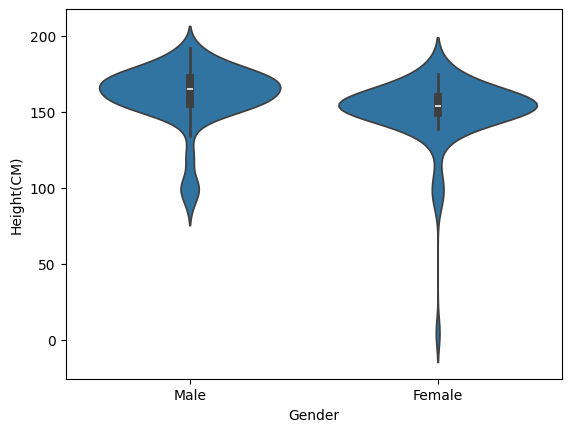

In [6]:
sns.violinplot(data=students, x="Gender", y="Height(CM)")

In [7]:
# we have some really wacky outliers as far as height goes, so we'll probably remove them so as to avoid
# their skewing the data

<Axes: xlabel='Gender', ylabel='Weight(KG)'>

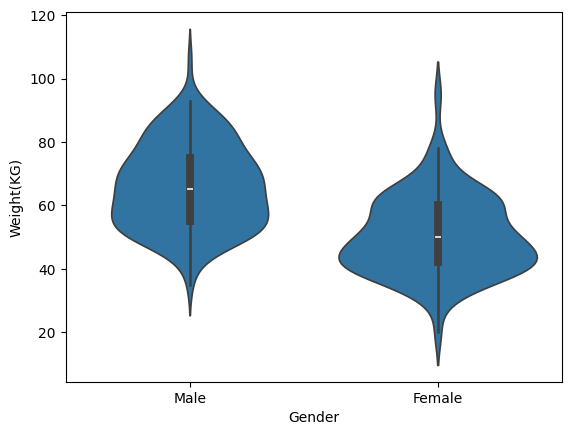

In [8]:
sns.violinplot(data=students, x="Gender", y="Weight(KG)")

In [9]:
# we also have some outliers in terms of weight, but it's less dramatic
# than with the height; nontheless, we'll remove those outliers

<Axes: xlabel='Gender', ylabel='10th Mark'>

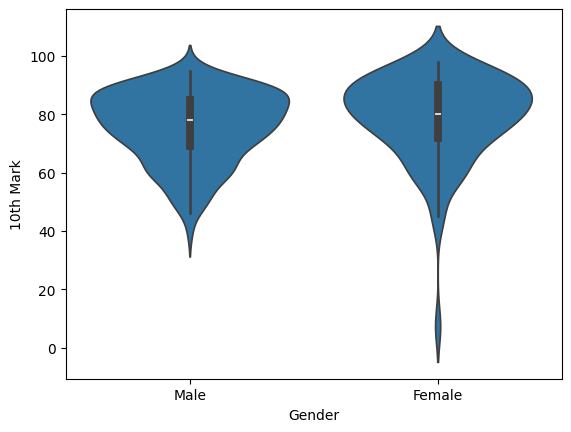

In [10]:
sns.violinplot(data=students, x="Gender", y="10th Mark")

<Axes: xlabel='Gender', ylabel='college mark'>

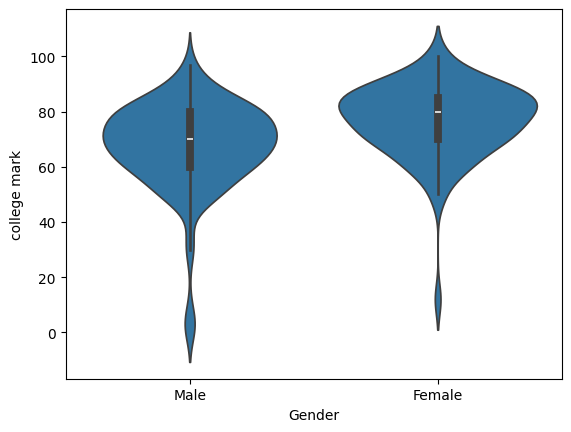

In [12]:
sns.violinplot(data=students, x="Gender", y="college mark")

<Axes: xlabel='Gender', ylabel='salary expectation'>

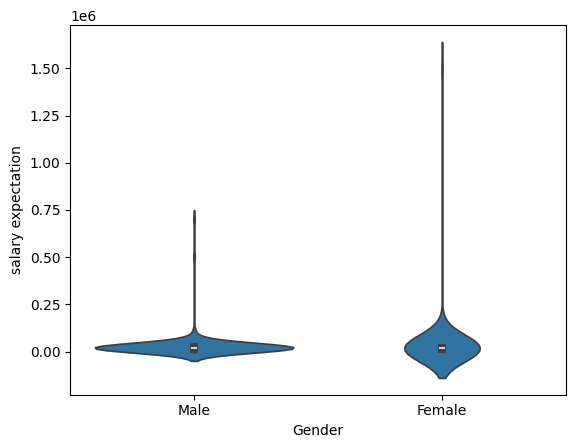

In [13]:
sns.violinplot(data=students, x="Gender", y="salary expectation")

<Axes: xlabel='Gender', ylabel='salary expectation'>

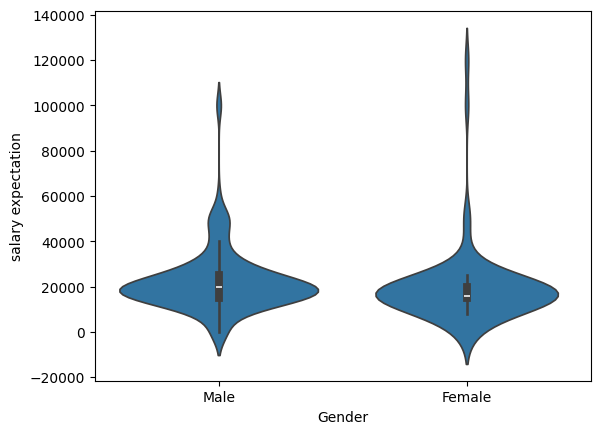

In [16]:
sns.violinplot(data=students[students["salary expectation"] < 500000], x="Gender", y="salary expectation")

In [17]:
students.shape

(235, 19)

In [18]:
# between the relatively low number of students and the number of outliers, we figure
# we'd likely be better off truncating the data (i.e. replacing high or low values)
# rather than removing them altogether

In [19]:
students.columns

Index(['Certification Course', 'Gender', 'Department', 'Height(CM)',
       'Weight(KG)', '10th Mark', '12th Mark', 'college mark', 'hobbies',
       'daily studing time', 'prefer to study in', 'salary expectation',
       'Do you like your degree?',
       'willingness to pursue a career based on their degree  ',
       'social medai & video', 'Travelling Time ', 'Stress Level ',
       'Financial Status', 'part-time job'],
      dtype='object')

In [29]:
# sorted([element for element in students['salary expectation']])
# with the height, there's only one student with a height so low
# that it's obviously an entry error, and it's also hard to correct,
# so we'll cut it out of the data
# we'll do the same for similar situations

students = students[students['Height(CM)'] > 4.5]
students = students[students['Weight(KG)'] > 20]

# we will also replace the very high value in the dataset to make it smoother
# - the observation will still be the highest

students.loc[students['Weight(KG)'] == 106.0, 'Weight(KG)'] = 100
students.loc[students['10th Mark'] == 7.4, '10th Mark'] = 39
students.loc[students['college mark'] < 30.0, 'college mark'] = 25
students.loc[students['salary expectation'] < 5000, 'salary expectation'] = 4500
students.loc[students['salary expectation'] > 60000.0, 'salary expectation'] = 65000

In [31]:
students.reset_index(drop=True, inplace=True)
students.shape
students.columns = [
    'certif', 'gender', 'department', 'height',
       'weight', '10_mark', '12_mark', 'college_mark', 'hobbies',
       'daily_studying_time', 'prefer_to_study_in', 'salary_expectation',
       'degree_affinity',
       'want_to_work_in_same_field',
       'social_med', 'travel_time ', 'stress',
       'financial_status', 'part_time_job'
]

In [33]:
students_scaled = students.copy()

list_of_columns_to_scale = [
    'height',
       'weight', '10_mark', '12_mark', 'college_mark', 'salary_expectation'
]

for column in list_of_columns_to_scale:
    min_of_column = min(students[column])
    max_of_column = max(students[column])
    
    students_scaled[column + "_scaled"] = (students[column] - min_of_column) / (max_of_column - min_of_column)
    
    
students_scaled.head(10)

,certif,gender,department,height,weight,10_mark,12_mark,college_mark,hobbies,daily_studying_time,...,travel_time,stress,financial_status,part_time_job,height_scaled,weight_scaled,10_mark_scaled,12_mark_scaled,college_mark_scaled,salary_expectation_scaled
0,No,Male,BCA,100.0,58.0,79.0,64.00,80.0,Video Games,0 - 30 minute,...,30 - 60 minutes,Bad,Bad,No,0.098039,0.382353,0.677966,0.387755,0.733333,0.586777
1,No,Female,BCA,90.0,40.0,70.0,80.00,70.0,Cinema,30 - 60 minute,...,0 - 30 minutes,Bad,Bad,No,0.000000,0.117647,0.525424,0.714286,0.600000,0.173554
2,Yes,Male,BCA,159.0,78.0,71.0,61.00,55.0,Cinema,1 - 2 Hour,...,30 - 60 minutes,Awful,Bad,No,0.676471,0.676471,0.542373,0.326531,0.400000,0.140496
3,No,Male,BCA,170.0,54.0,40.0,65.00,30.0,Video Games,30 - 60 minute,...,30 - 60 minutes,Good,good,No,0.784314,0.323529,0.016949,0.408163,0.066667,0.752066
4,Yes,Female,BCA,139.0,33.0,90.0,75.00,70.0,Cinema,30 - 60 minute,...,0 - 30 minutes,Bad,good,No,0.480392,0.014706,0.864407,0.612245,0.600000,0.256198
5,Yes,Male,BCA,165.0,50.0,70.0,63.00,25.0,Reading books,1 - 2 Hour,...,1 - 1.30 hour,Good,good,No,0.735294,0.264706,0.525424,0.367347,0.000000,0.173554
6,No,Male,BCA,152.0,43.0,61.6,61.67,75.0,Sports,1 - 2 Hour,...,1 - 1.30 hour,Good,good,No,0.607843,0.161765,0.383051,0.340204,0.666667,0.338843
7,No,Male,BCA,190.0,85.0,88.2,67.50,60.0,Video Games,0 - 30 minute,...,1 - 1.30 hour,Bad,Bad,No,0.980392,0.779412,0.833898,0.459184,0.466667,0.256198
8,No,Male,BCA,150.0,84.0,60.0,65.00,70.0,Video Games,0 - 30 minute,...,30 - 60 minutes,Good,good,No,0.588235,0.764706,0.355932,0.408163,0.600000,0.256198
9,No,Male,BCA,99.0,50.0,75.0,70.00,60.0,Video Games,1 - 2 Hour,...,0 - 30 minutes,Good,Bad,No,0.088235,0.264706,0.610169,0.510204,0.466667,0.223140


In [34]:

le = LabelEncoder()

columns_to_encode = [
     'certif', 'gender', 'department', 'hobbies',
       'daily_studying_time', 'prefer_to_study_in',
       'degree_affinity',
       'want_to_work_in_same_field',
       'social_med', 'travel_time ', 'stress',
       'financial_status', 'part_time_job'
]

for column in columns_to_encode:
    students_scaled[column + '_encoded'] = le.fit_transform(students_scaled[column])
    students_scaled.drop(columns=[column], inplace=True)

students_scaled.head(5)

,height,weight,10_mark,12_mark,college_mark,salary_expectation,height_scaled,weight_scaled,10_mark_scaled,12_mark_scaled,...,hobbies_encoded,daily_studying_time_encoded,prefer_to_study_in_encoded,degree_affinity_encoded,want_to_work_in_same_field_encoded,social_med_encoded,travel_time _encoded,stress_encoded,financial_status_encoded,part_time_job_encoded
0,100.0,58.0,79.0,64.0,80.0,40000,0.098039,0.382353,0.677966,0.387755,...,3,0,1,0,3,3,5,1,1,0
1,90.0,40.0,70.0,80.0,70.0,15000,0.000000,0.117647,0.525424,0.714286,...,0,4,1,1,4,1,0,1,1,0
2,159.0,78.0,71.0,61.0,55.0,13000,0.676471,0.676471,0.542373,0.326531,...,0,1,0,1,3,5,5,0,1,0
3,170.0,54.0,40.0,65.0,30.0,50000,0.784314,0.323529,0.016949,0.408163,...,3,4,1,1,2,3,5,2,3,0
4,139.0,33.0,90.0,75.0,70.0,20000,0.480392,0.014706,0.864407,0.612245,...,0,4,2,1,3,4,0,1,3,0


In [38]:
# the dataset seems to be ready for clustering,
# so we'll also create a copy and center the continuous variables in it to prep it for PCA
students_scaled_centered = students_scaled.copy()

columns_to_center = [col_name + "_scaled" for col_name in list_of_columns_to_scale]

for column in columns_to_center:
    students_scaled_centered[column + "_and_centered"] = (
        students_scaled_centered[column] - students_scaled_centered[column].mean())

students_scaled_centered.drop(columns=columns_to_center, inplace=True)
students_scaled_centered.drop(columns=list_of_columns_to_scale, inplace=True)

students_scaled_centered.head(10)

,certif_encoded,gender_encoded,department_encoded,hobbies_encoded,daily_studying_time_encoded,prefer_to_study_in_encoded,degree_affinity_encoded,want_to_work_in_same_field_encoded,social_med_encoded,travel_time _encoded,stress_encoded,financial_status_encoded,part_time_job_encoded,height_scaled_and_centered,weight_scaled_and_centered,10_mark_scaled_and_centered,12_mark_scaled_and_centered,college_mark_scaled_and_centered,salary_expectation_scaled_and_centered
0,0,1,2,3,0,1,0,3,3,5,1,1,0,-0.569637,-0.044616,0.034262,-0.096464,0.118928,0.311921
1,0,0,2,0,4,1,1,4,1,0,1,1,0,-0.667677,-0.309322,-0.118280,0.230067,-0.014405,-0.101302
2,1,1,2,0,1,0,1,3,5,5,0,1,0,0.008794,0.249501,-0.101331,-0.157689,-0.214405,-0.134360
3,0,1,2,3,4,1,1,2,3,5,2,3,0,0.116637,-0.103440,-0.626755,-0.076056,-0.547738,0.477211
4,1,0,2,0,4,2,1,3,4,0,1,3,0,-0.187284,-0.412263,0.220703,0.128026,-0.014405,-0.018657
5,1,1,2,1,1,1,1,4,1,1,2,3,0,0.067618,-0.162263,-0.118280,-0.116872,-0.614405,-0.101302
6,0,1,2,2,1,1,1,3,1,1,2,3,0,-0.059833,-0.265204,-0.260653,-0.144015,0.052262,0.063988
7,0,1,2,3,0,1,1,4,3,1,1,1,0,0.312716,0.352443,0.190194,-0.025035,-0.147738,-0.018657
8,0,1,2,3,0,0,1,4,4,5,2,3,0,-0.079441,0.337737,-0.287772,-0.076056,-0.014405,-0.018657
9,0,1,2,3,1,1,1,4,1,0,2,1,0,-0.579441,-0.162263,-0.033535,0.025985,-0.147738,-0.051715
